<a href="https://colab.research.google.com/github/ramkamal2000/DeepLearning.ai-Summary/blob/master/PartB_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb
!pip install tensorflow
!pip install keras

     |████████████████████████████████| 2.1MB 19.2MB/s 
     |████████████████████████████████| 163kB 53.7MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 133kB 50.9MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=3d2def4ee83905438b36788fa7024cd12d9b5dc5dd87a2ae15f0553bdcfb125f
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=1cc92116874fd7646b996d974f2f4a6f64ed3b7de3877474823b00efe5a53c9f
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import shutil
import pprint
import wandb
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
from keras.applications import InceptionV3, InceptionResNetV2, ResNet50, Xception

In [ ]:
!wget -nc https://storage.googleapis.com/wandb_datasets/nature_12K.zip
if not os.path.isdir('/content/inaturalist_12K'):
  ZipFile('/content/nature_12K.zip').extractall()

--2021-04-11 13:07:33--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 172.217.7.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G  62.1MB/s    in 65s     

2021-04-11 13:08:37 (56.2 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [ ]:
# wandb.login(key='14394907543f59ea21931529e34b4d80d2ca8c9c')
wandb.login(key='feaed71a1d227d1c2ec9d80e592582248a32f930', force=True)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
train_val_dir = '/content/inaturalist_12K/train'
test_dir = '/content/inaturalist_12K/val'

In [ ]:
class dataset:
  @staticmethod
  def train_val_test_data_loader(train_val_dir, test_dir, val_split=0.2, seed=6910, image_size=(299, 299), batch_size=32):

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_val_dir,
        validation_split=val_split,
        subset="training",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
        )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_val_dir,
        validation_split=val_split,
        subset="validation",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
        )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        
        test_dir,
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
        )

    print(train_ds.class_names)

    return {
        'train': train_ds, 
        'val': val_ds,
        'test': test_ds
    }

  @staticmethod
  def display_samples(ds, figsize=(10,10)):
    class_names = ds.class_names
    plt.figure(figsize=figsize)
    for images, labels in ds.take(1):
      for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Found 9999 files belonging to 10 classes.
Using 8000 files for training.
Found 9999 files belonging to 10 classes.
Using 1999 files for validation.
Found 2000 files belonging to 10 classes.
['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


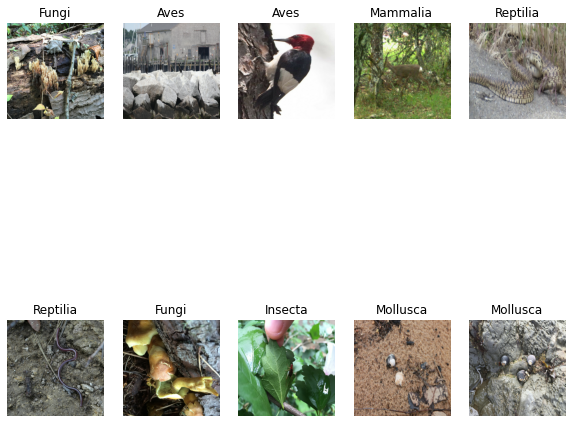

In [ ]:
data = dataset.train_val_test_data_loader(train_val_dir, test_dir)
dataset.display_samples(data['train'], (10, 10))

In [ ]:
class cnn :
  def __init__(self, params):
    
    img_shape = params['img_shape']
    activation = params['activation']
    num_classes = params['num_classes']
    dropout = params['dropout']
    dense_layer_size = params['dense_layer_size']
    pre_trained = params['pre_trained']
    top_K = params['top_K']
    augmentation = params['augmentation']

    new_input = Input(shape=img_shape)
    rescaled_input = layers.experimental.preprocessing.Rescaling(1./255)(new_input)

    # data augmentation
    if augmentation:
      rescaled_input = layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')(rescaled_input)
      rescaled_input = layers.experimental.preprocessing.RandomRotation(0.1)(rescaled_input)
      rescaled_input = layers.experimental.preprocessing.RandomTranslation(0.3,0.3)(rescaled_input)

    if pre_trained == 'InceptionV3': 
      pre_trained_model = InceptionV3(input_tensor=rescaled_input, 
                                      include_top=False,
                                      weights='imagenet'
                                      )
  
    elif pre_trained == 'InceptionResNetV2':
      pre_trained_model = InceptionResNetV2(input_tensor=rescaled_input, 
                                            include_top=False,
                                            weights='imagenet'
                                            )
      
    elif pre_trained == 'ResNet50':
      pre_trained_model = ResNet50(input_tensor=rescaled_input,
                                   include_top=False,
                                   weights='imagenet'
                                   )

    elif pre_trained == 'Xception':
      pre_trained_model = Xception(input_tensor=rescaled_input,
                                   include_top=False,
                                   weights='imagenet'
                                   )

    # number of layers
    num_layers = len(pre_trained_model.layers)

    # freezing weights of bottom layers
    for i in range(num_layers - top_K):
      pre_trained_model.layers[i].trainable = False

    X = layers.Flatten()(pre_trained_model.layers[-1].output)
    X = layers.Dense(dense_layer_size, activation=activation)(X)
    X = layers.Dropout(dropout)(X)
    X = layers.Dense(num_classes, activation='softmax')(X)

    model = Model(new_input, X)
    self.model = model
    

  def compile_and_fit(self, data, params) :
   
    train_ds, val_ds = data['train'], data['val']
    optimizer, epochs = params['optimizer'], params['num_epochs']

    self.model.compile(optimizer=optimizer, 
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                       metrics=['accuracy']#, 'categorical_crossentropy']
                       )
    
    summary = self.model.summary()

    run_details = self.model.fit(train_ds, 
                                 validation_data=val_ds, 
                                 epochs=epochs,
                                 callbacks=[wandb.keras.WandbCallback(save_model=False),
                                            keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                                           patience=3, 
                                                                           min_delta=0.0025)]
                                 )
    
    return {
        'summary': summary,
        'run_details' : run_details
    }

  # def test_model(self,data) :
    # use self.model.predict()

In [ ]:
# network.compile_and_fit(data, params)

In [ ]:
class cnn_tools:
  def init_params(config):
    '''
  def init_params(img_shape=(700, 700, 3), activation='relu', 
                  filter_size=(3, 3), dense_layer_size=128, 
                  type_of_filters='same', num_filters_=16, 
                  num_epochs=10, dropout=0., 
                  batch_norm=False, optimizer='adam', 
                  num_layers=5, num_classes=10) :
    '''
    
    # returning parameters
    params = {
        'pre_trained' : config.pre_trained,
        'top_K' : config.top_K,
        'activation' : config.activation,
        'num_classes' : 10,
        'img_shape' : (299, 299, 3),
        'dropout' : config.dropout,
        'dense_layer_size' : config.dense_layer_size,
        'num_epochs' : config.num_epochs,
        'optimizer' : config.optimizer,
        'augmentation': config.augmentation
    }

    return params


In [ ]:
# sweep configuration
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'val_accuracy',
        'goal' : 'maximize'
    },
    'parameters': {
        'pre_trained' :
        {
            'values': ['InceptionV3', 'InceptionResNetV2', 'ResNet50', 'Xception']
        },
        'top_K' : {
            'values' : [0, 5, 10, 20, 40, 60, 80, 100]
        },
        'dense_layer_size': {
            'values': [256, 512]
        },
        'dropout': {
            'values': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
        },
        'optimizer': {
            'values': ['adam']
        },
        'batch_size': {
            'values': [8, 16, 32]
        },
        'num_epochs': {
            'values': [15]
        },
        'activation': {
            'values': ['tanh', 'relu']
        },
        'augmentation': {
            'values': [True, False]
        }        
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='inaturalist_partB_v4')

Create sweep with ID: p5ygh3sx
Sweep URL: https://wandb.ai/ramkamal/inaturalist_partB_v4/sweeps/p5ygh3sx


In [ ]:
# sweep_id = 'p5ygh3sx'

In [ ]:
pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'parameters': {'activation': {'values': ['tanh', 'relu']},
                'augmentation': {'values': [True, False]},
                'batch_size': {'values': [8, 16, 32]},
                'dense_layer_size': {'values': [256, 512]},
                'dropout': {'values': [0, 0.1, 0.2, 0.3, 0.4, 0.5]},
                'num_epochs': {'values': [15]},
                'optimizer': {'values': ['adam']},
                'pre_trained': {'values': ['InceptionV3',
                                           'InceptionResNetV2',
                                           'ResNet50',
                                           'Xception']},
                'top_K': {'values': [0, 5, 10, 20, 40, 60, 80, 100]}}}


In [ ]:
class sweep_module:
  @staticmethod
  def train(config=None):

    with wandb.init(config):
      
      config = wandb.config
 
      wandb.run.name = 'pre:'+config['pre_trained']+'_k:'+str(config['top_K'])
      params = cnn_tools.init_params(config)
      network = cnn(params)
      data = dataset.train_val_test_data_loader(train_val_dir, test_dir, batch_size=config.batch_size)

      summary, run_details = network.compile_and_fit(data, params)

      if os.path.isdir('/content/wandb'): 
        shutil.rmtree('/content/wandb')

In [ ]:
# performing the sweep
wandb.agent(sweep_id, sweep_module.train)

wandb: Agent Starting Run: vpoihww0 with config:
wandb: 	activation: relu
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	dense_layer_size: 512
wandb: 	dropout: 0
wandb: 	num_epochs: 15
wandb: 	optimizer: adam
wandb: 	pre_trained: ResNet50
wandb: 	top_K: 60
wandb: Currently logged in as: ramkamal (use `wandb login --relogin` to force relogin)


94773248/94765736 [==============================] - 1s 0us/step
179
60
Found 9999 files belonging to 10 classes.
Using 8000 files for training.
Found 9999 files belonging to 10 classes.
Using 1999 files for validation.
Found 2000 files belonging to 10 classes.
['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
random_flip (Ran